In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Read Data

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
df = df.sample(frac=1).reset_index(drop=True)
df = df[['target',
 'exang',
 'cp',
 'oldpeak',
 'thalach',
 'ca',
 'slope',
 'thal',
 'sex',
 'age',
 'trestbps',
 'restecg']]

In [4]:
train_frac = 0.33
test_frac = 0.33

train_X = df[[c for c in df.columns if c != 'target']].iloc[:int(len(df) * train_frac)].values
train_y = df.target.iloc[:int(len(df) * train_frac)].values

test_X = df[[c for c in df.columns if c != 'target']].iloc[int(len(df) * train_frac):int(len(df) * (train_frac+test_frac))].values
test_y = df.target.iloc[int(len(df) * train_frac):int(len(df) * (train_frac+test_frac))].values

valid_X = df[[c for c in df.columns if c != 'target']].iloc[int(len(df) * (train_frac+test_frac)):].values
valid_y = df.target.iloc[int(len(df) * (train_frac+test_frac)):].values

# Train Models and get Probabilities

In [5]:
model_to_clf = {
    'rf': RandomForestClassifier,
    'svc': SVC,
    'nb': GaussianNB
               }

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.svm._classes.SVC'>
<class 'sklearn.naive_bayes.GaussianNB'>


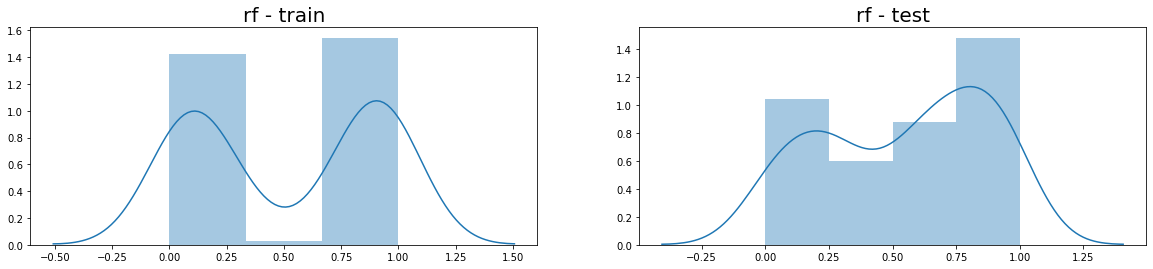

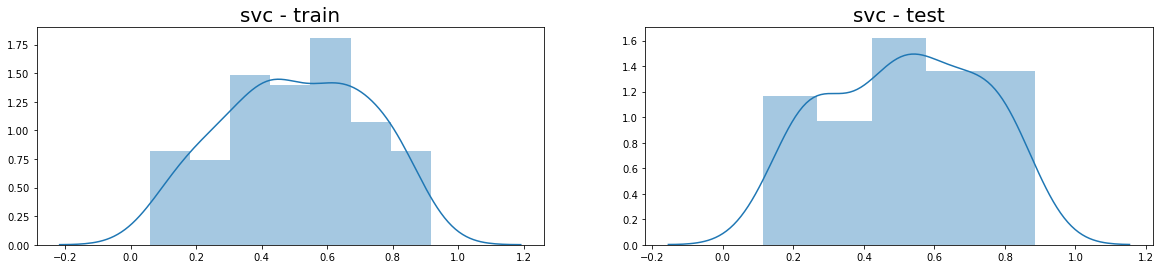

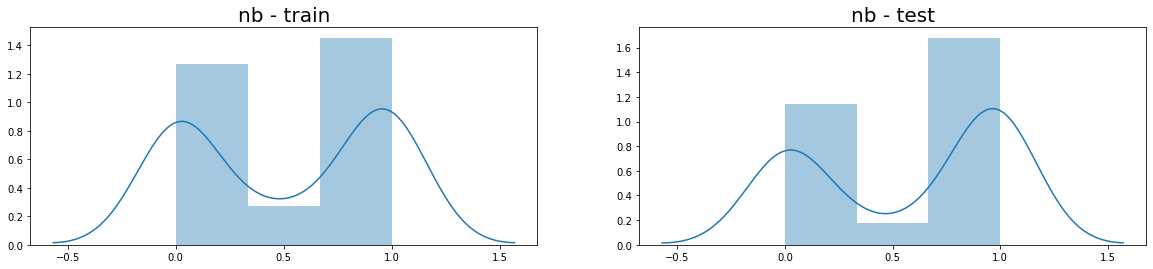

In [6]:
model_to_probs = {}
model_str_to_trained_model = {}

for model_str, model in model_to_clf.items():
    print(model)
    if model == SVC:
        clf = model(probability=True)
    elif model == LogisticRegression:
        clf = model(solver='liblinear')
    else:
        clf = model()
        
    clf.fit(train_X, train_y)
    
    pred_probs_train = clf.predict_proba(train_X)[:,1]
    pred_probs_test = clf.predict_proba(test_X)[:,1]
    pred_probs_valid = clf.predict_proba(valid_X)[:,1]
    
    model_to_probs[model_str] = {'train': pred_probs_train, 'test': pred_probs_test, 'valid': pred_probs_valid}
    
    plt.figure(figsize=(20,4))
    
    plt.subplot(1,2,1)
    sns.distplot(pred_probs_train)
    plt.title(f"{model_str} - train", fontsize=20)
    
    plt.subplot(1,2,2)
    sns.distplot(pred_probs_test)
    plt.title(f"{model_str} - test", fontsize=20)
    
    model_str_to_trained_model[model_str] = clf

# Plot Predicted Probabilities vs Empirical Probabilities

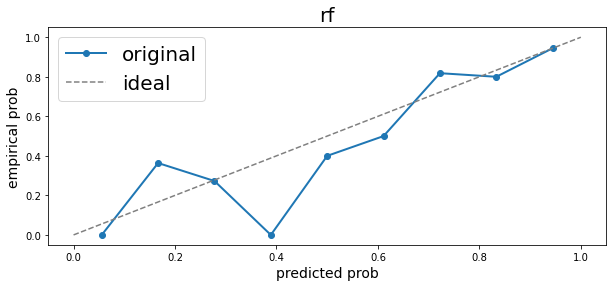

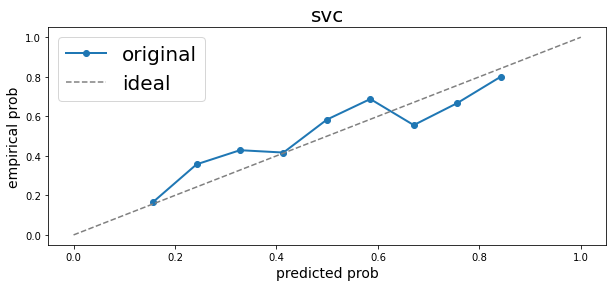

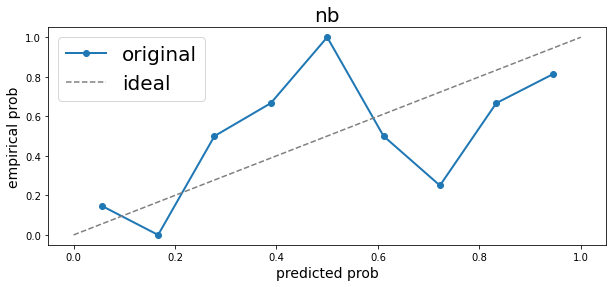

In [7]:
for model_str, pred_prob_dict in model_to_probs.items():
    pred_probs = pred_prob_dict['test']

    pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

    empirical_probs = []
    pred_probs_midpoints = []

    for i in range(len(pred_probs_space)-1):
        empirical_probs.append(np.mean(test_y[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]))
        pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

    plt.figure(figsize=(10,4))
    plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
    plt.title(f"{model_str}", fontsize=20)
    plt.xlabel('predicted prob', fontsize=14)
    plt.ylabel('empirical prob', fontsize=14)
    
    plt.plot([0,1],[0,1],linestyle='--',color='gray')
    
    plt.legend(['original', 'ideal'], fontsize=20)

# Calibrate

C:\Users\ritvik\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ritvik\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


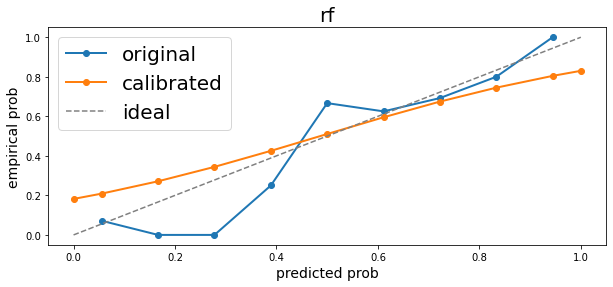

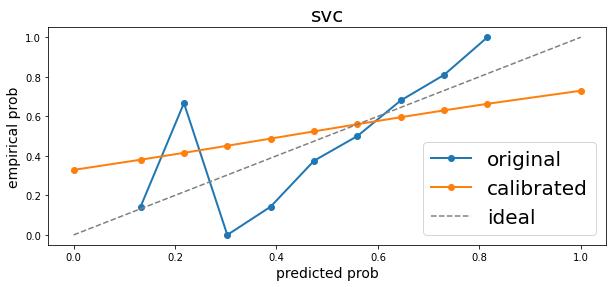

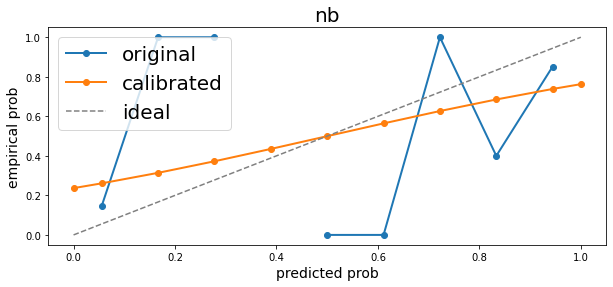

In [8]:
model_str_to_calibrator = {}

for model_str, pred_prob_dict in model_to_probs.items():
    #train calibration model
    lr_model = LogisticRegression()
    lr_model.fit(pred_prob_dict['test'].reshape(-1,1), test_y)
    
    pred_probs = pred_prob_dict['valid']

    pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

    empirical_probs = []
    pred_probs_midpoints = []

    for i in range(len(pred_probs_space)-1):
        empirical_probs.append(np.mean(valid_y[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]))
        pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

    calibrated_probs = lr_model.predict_proba(np.array([0.0]+pred_probs_midpoints+[1.0]).reshape(-1,1))[:,1]
    
    plt.figure(figsize=(10,4))
    plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
    plt.title(f"{model_str}", fontsize=20)
    plt.xlabel('predicted prob', fontsize=14)
    plt.ylabel('empirical prob', fontsize=14)
    
    plt.plot([0.0]+pred_probs_midpoints+[1.0], calibrated_probs, linewidth=2, marker='o')
    
    plt.plot([0,1],[0,1],linestyle='--',color='gray')
    
    plt.legend(['original', 'calibrated', 'ideal'], fontsize=20)
    
    model_str_to_calibrator[model_str] = lr_model

# How do we use this?

## (1) Get base model

In [88]:
clf = model_str_to_trained_model['rf']

## (2) Get calibration layer 

In [89]:
lr = model_str_to_calibrator['rf']

## (3) Get calibrated predicted probability using model + calibration

In [85]:
new_sample = np.array([[1, 0, 0.6, 110, 1, 0, 0, 1, 85, 170, 0]])

In [86]:
uncal_prob = clf.predict_proba(new_sample)[:,1][0]
print('Uncalibrated Prob:', uncal_prob)

Uncalibrated Prob: 0.14


In [87]:
cal_prob = lr.predict_proba(np.array([[uncal_prob]]))[:,1][0]
print('Calibrated Prob:', cal_prob)

Calibrated Prob: 0.2553911858824181
